# MRI Brain Connectivity Practica

Grado en Física - University of Barcelona
Asignatura: Física Médica, 24/25
Profesora: María Cabello-Toscano
(mr.cabello-toscano@ub.edu)

## Introducción

En esta práctica exploraremos cómo, a partir de datos de resonancia magnética funcional (fMRI), podemos construir y analizar matrices de conectividad cerebral para entender las interacciones entre diferentes regiones del cerebro.

*    **MRI funcional (fMRI)**: mide cambios en la oxigenación y el flujo sanguíneo relacionados con la actividad neuronal, a través de la señal BOLD (Blood Oxygen Level Dependent).

*    **MRI estructural (DWI/DTI)**: evalúa la conectividad física del cerebro mediante la tractografía, que reconstruye los trayectos de las fibras nerviosas.

*    **Conectividad funcional**: se estima calculando las correlaciones temporales entre las señales BOLD de distintas regiones cerebrales.

*    **Conectividad estructural**: se representa mediante matrices de adyacencia basadas en la existencia y cantidad de fibras que conectan pares de regiones.

Por simplicidad, en este notebook limitaremos el cálculo de conectividad funcional a partir de datos fMRI reales.



In [7]:
try:
    import nilearn
except ImportError:
    # if not, install it using pip
    !pip install nilearn
    import nilearn

try:
    import nibabel as nib
except ImportError:
    # if not, install it using pip
    !pip install nibabel
    import nibabel as nib

try:
  import numpy as np
except ImportError:
    # if not, install it using pip
    !pip install numpy
    import numpy as np

try:
  import dipy
except ImportError:
    # if not, install it using pip
    !pip install dipy

### fMRI - BOLD
En esta sección cargaremos datos de imágenes de resonancia magnética funcional (fMRI), para explorar sus características básicas y preparar el terreno para análisis posteriores.

Una imagen BOLD, 4D, contiene señales cerebrales a lo largo del tiempo.

El dataset utilizado proviene del proyecto de desarrollo del cerebro (HBN), que contiene imágenes BOLD con alta resolución temporal.

In [9]:
# Importar librerías necesarias
from nilearn import datasets, plotting
from nilearn.image import load_img
import nibabel as nib
import numpy as np

# Descargar datos fMRI para un sujeto
data = datasets.fetch_development_fmri(n_subjects=1)

# Cargar la imagen funcional 4D
fmri_img = load_img(data.func[0])


# Mostrar dimensiones (x, y, z, tiempo)
print(f"Dimensiones de la imagen BOLD (x, y, z, tiempo): {fmri_img.shape}")

# Extraer TR del header
img_nib = nib.load(data.func[0])
tr = img_nib.header.get_zooms()[3]
print(f"Tiempo de repetición (TR): {tr} segundos")

[_add_readme_to_default_data_locations] Added README.md to C:\Users\Usuario\nilearn_data

[get_dataset_dir] Dataset created in C:\Users\Usuario\nilearn_data\development_fmri

[_add_readme_to_default_data_locations] Added README.md to C:\Users\Usuario\nilearn_data\development_fmri

[get_dataset_dir] Dataset created in C:\Users\Usuario\nilearn_data\development_fmri\development_fmri

[fetch_single_file] Downloading data from https://osf.io/yr3av/download ...

[fetch_single_file]  ...done. (2 seconds, 0 min)

[get_dataset_dir] Dataset found in C:\Users\Usuario\nilearn_data\development_fmri\development_fmri

[fetch_single_file] Downloading data from https://osf.io/download/5c8ff3df4712b400183b7092/ ...

[fetch_single_file]  ...done. (2 seconds, 0 min)

[fetch_single_file] Downloading data from https://osf.io/download/5c8ff3e04712b400193b5bdf/ ...

[fetch_single_file]  ...done. (2 seconds, 0 min)

Dimensiones de la imagen BOLD (x, y, z, tiempo): (50, 59, 50, 168)
Tiempo de repetición (TR): 1.0 segundos


 🤔 **Pregunta**: ¿Cuál es la duración total de la adquisición en minutos?

In [11]:
# TU RESPUESTA: 2.8 mins

 Visualizamos el primer volumen para apreciar la anatomía y la calidad de la imagen.

C:\Users\Usuario\anaconda3\Lib\site-packages\nilearn\plotting\html_stat_map.py:109: UserWarning: Threshold given was 1e-06, but the data has no values below -116.05355072021484. 
  warnings.warn(
C:\Users\Usuario\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



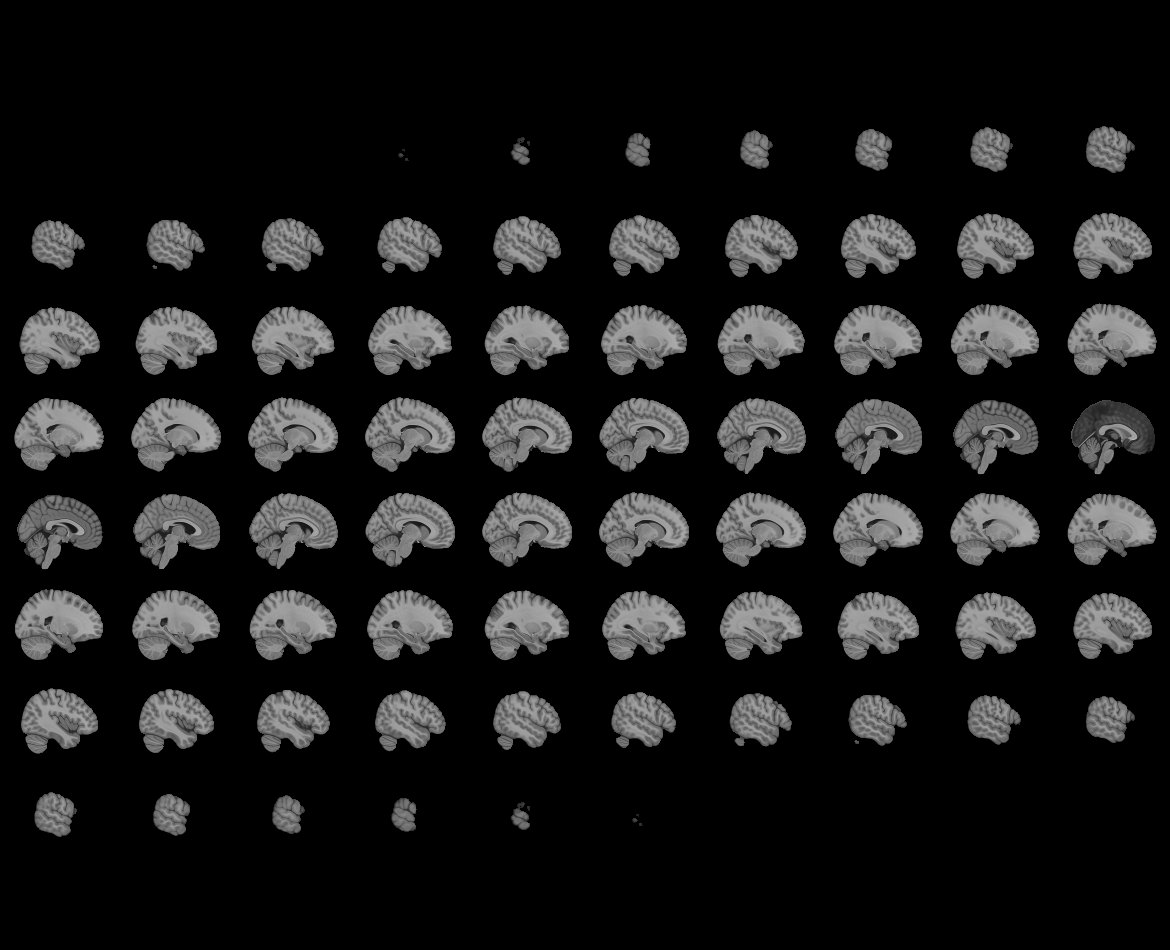
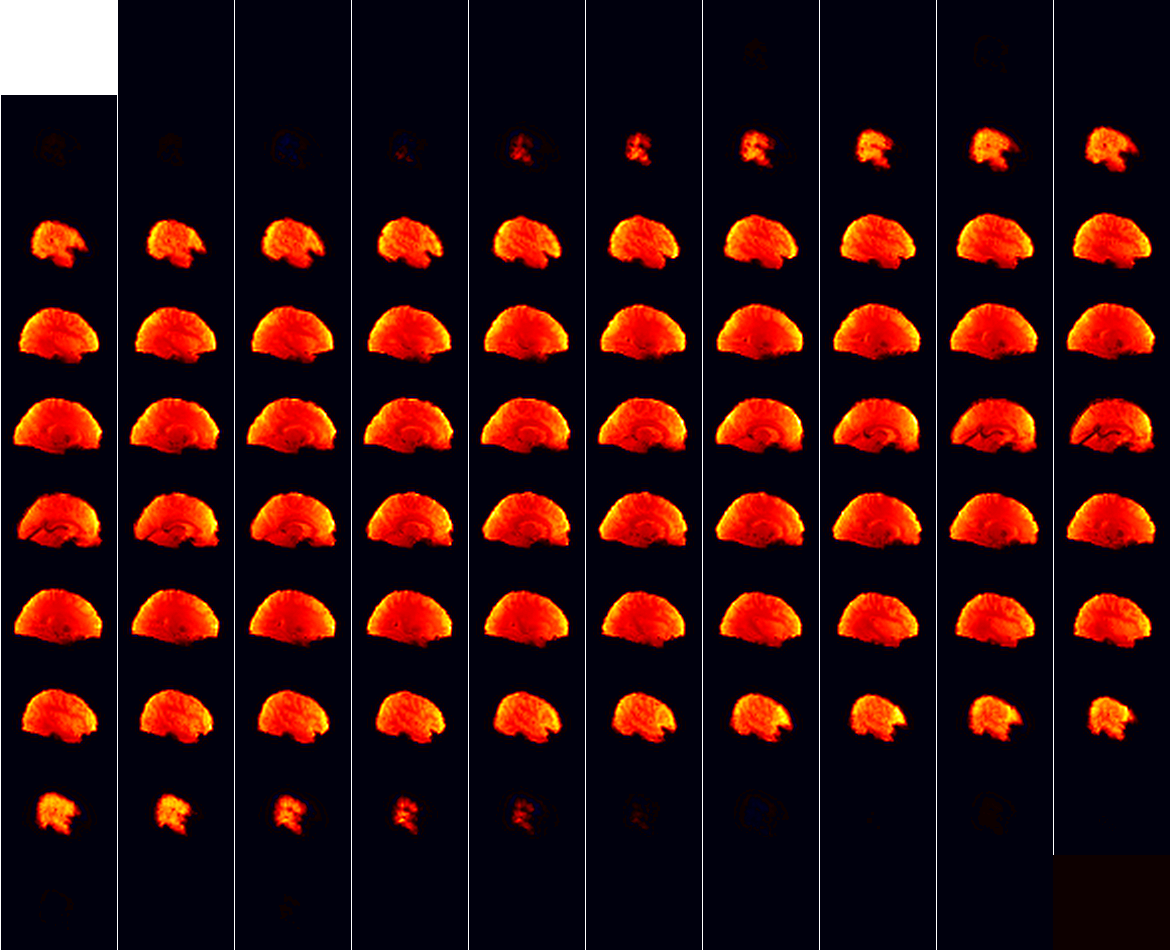

In [14]:
# Visualización del primer volumen temporal (volumen 0)
from nilearn import plotting
first_vol = fmri_img.slicer[..., 0]

plotting.view_img(first_vol, title='Primer volumen BOLD')

Ahora vamos a graficar las series temporales correspondientes a dos voxeles. Elije en el gráfico interactivo anterior un voxel en la materia gris y otro en la materia blanca y escribe sus coordenadas (x,y,z) en la siguiente caja de código:

In [16]:
xyz_mni_gray = (-8,62,26)
xyz_mni_white = (24,30,26)

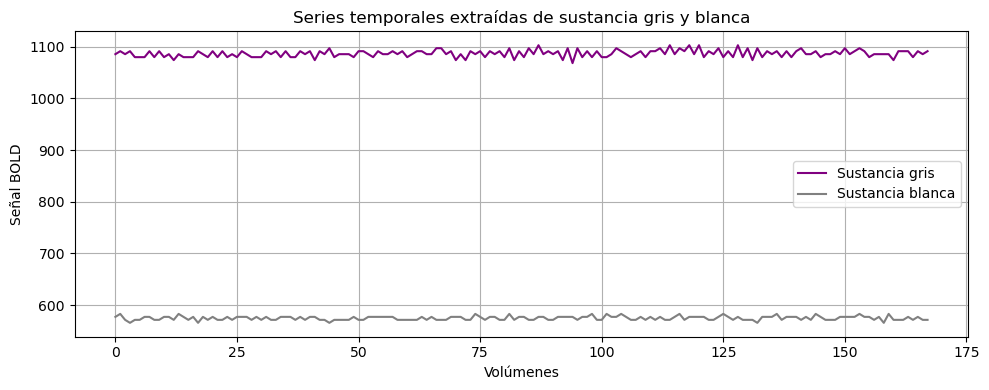

In [18]:
import matplotlib.pyplot as plt

# Transformación de las coordenadas en espacio MNI (dada por el visor) a las coordenadas dentro de la matriz de datos (voxeles)
voxel_coords_gray = np.round(np.linalg.inv(img_nib.affine) @ np.append(xyz_mni_gray, 1))[:3].astype(int)
voxel_coords_white = np.round(np.linalg.inv(img_nib.affine) @ np.append(xyz_mni_white, 1))[:3].astype(int)

# Extracción de la matriz de datos de la imagen
fmri_data = fmri_img.get_fdata()

# Extracción de series temporales
timeseries_gray=fmri_data[voxel_coords_gray[0],voxel_coords_gray[1],voxel_coords_gray[2],:]
timeseries_white=fmri_data[voxel_coords_white[0],voxel_coords_white[1],voxel_coords_white[2],:]

# Graficamos las series temporales
plt.figure(figsize=(10, 4))
plt.plot(timeseries_gray, label='Sustancia gris', color='purple')
plt.plot(timeseries_white, label='Sustancia blanca', color='gray')
plt.xlabel('Volúmenes')
plt.ylabel('Señal BOLD')
plt.title('Series temporales extraídas de sustancia gris y blanca')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Al observar las series temporales extraídas de la sustancia gris y la sustancia blanca, podemos notar algunas diferencias importantes:

🟣 Sustancia gris: suele mostrar mayor variabilidad y estructura temporal, ya que contiene las neuronas que generan la señal BOLD funcional. La actividad aquí está relacionada con procesos cognitivos y sensoriomotores.

⚪ Sustancia blanca: típicamente presenta una señal más plana o menos estructurada, ya que su contenido (axones mielinizados) no contribuye directamente a la señal funcional. Muchas veces actúa como referencia de "ruido fisiológico".

## Atlas en espacio estándar

[get_dataset_dir] Dataset created in C:\Users\Usuario\nilearn_data\schaefer_2018

[fetch_single_file] Downloading data from 
https://raw.githubusercontent.com/ThomasYeoLab/CBIG/v0.14.3-Update_Yeo2011_Schaefer2018_labelname/stable_projects/b
rain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Schaefer2018_100Parcels_7Networks_order.txt ...

[fetch_single_file]  ...done. (1 seconds, 0 min)

[fetch_single_file] Downloading data from 
https://raw.githubusercontent.com/ThomasYeoLab/CBIG/v0.14.3-Update_Yeo2011_Schaefer2018_labelname/stable_projects/b
rain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.
nii.gz ...

[fetch_single_file]  ...done. (0 seconds, 0 min)

dict_keys(['maps', 'labels', 'description'])


C:\Users\Usuario\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



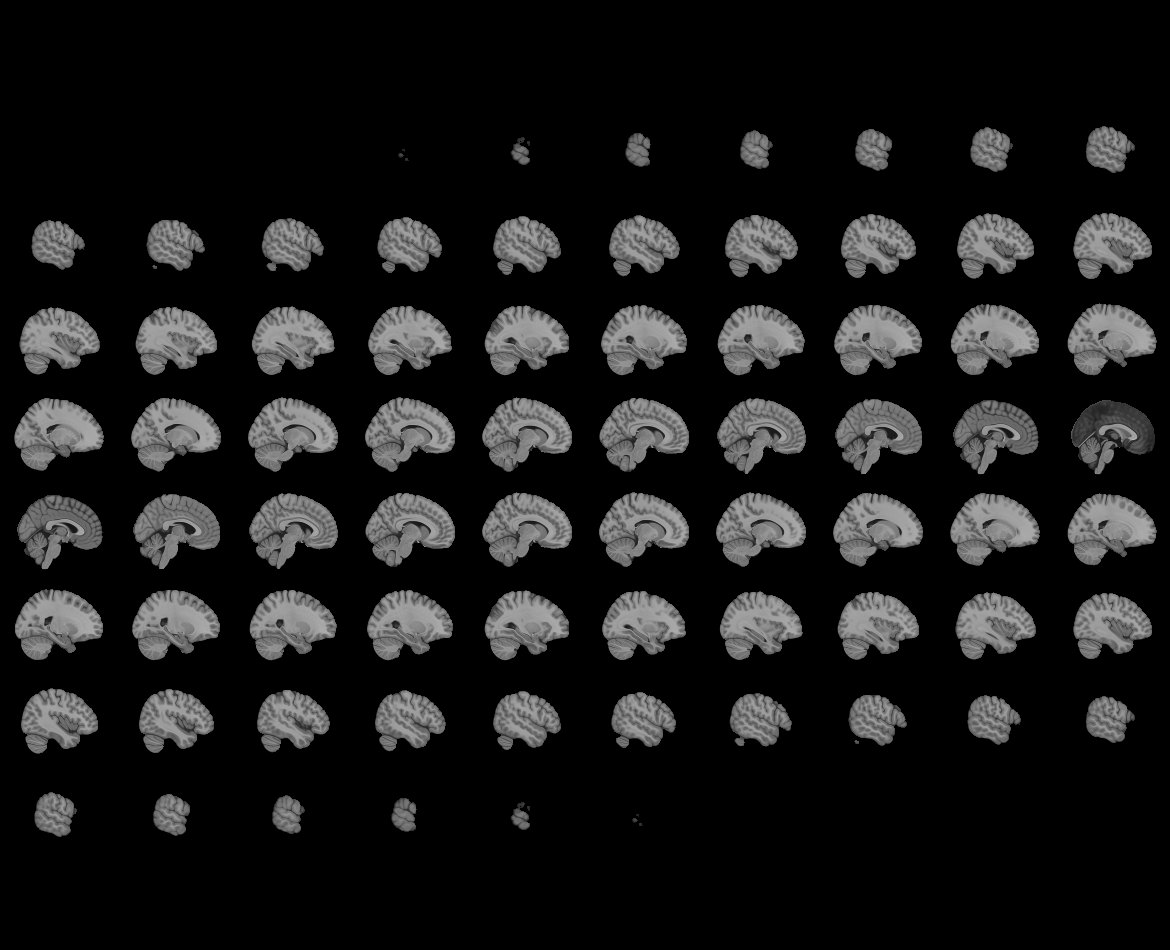
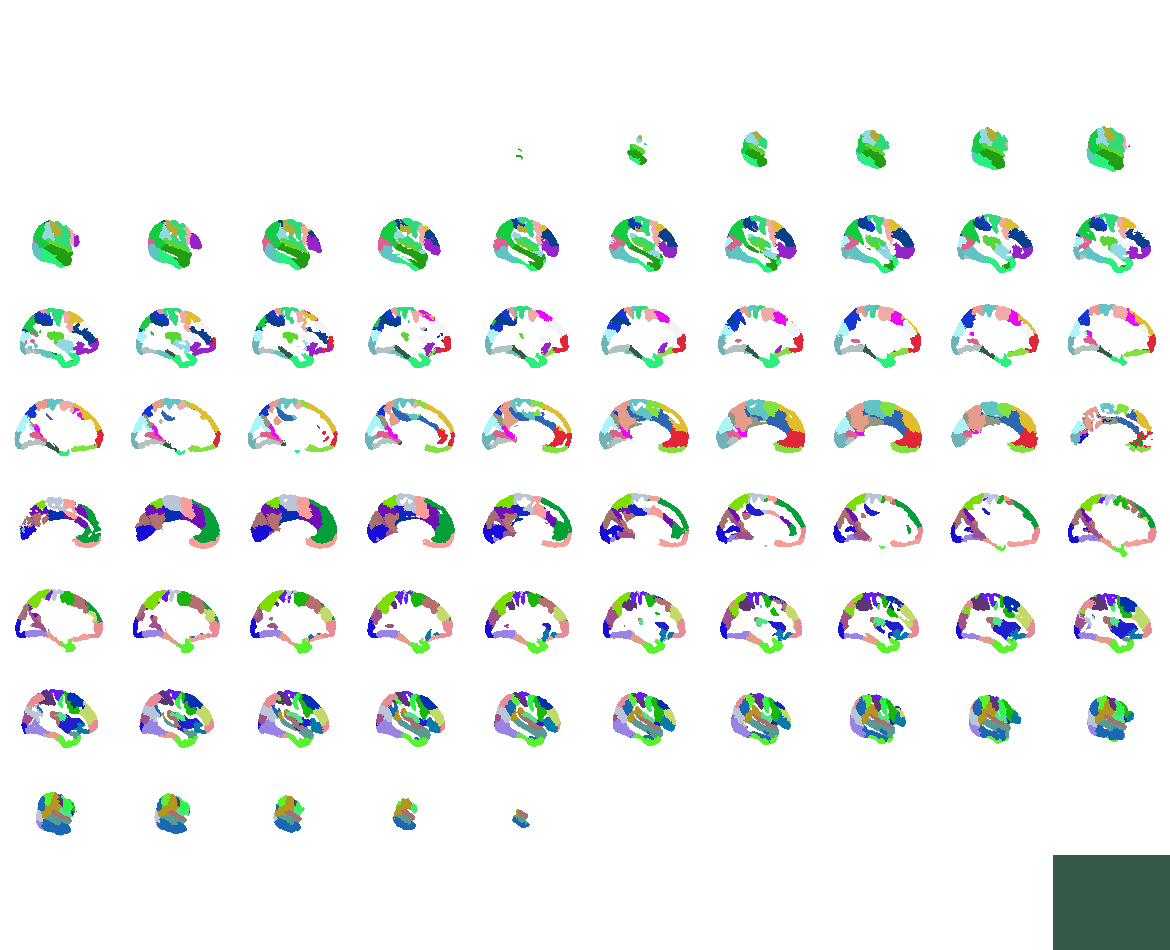

In [20]:
import nilearn.datasets

# Descarga el atlas Schaefer con 100 regiones, 7 redes
atlas = nilearn.datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7, resolution_mm=1)

print(atlas.keys())

atlas_nii = nib.load(atlas['maps'])
atlas_data = atlas_nii.get_fdata()

from nilearn import plotting
from matplotlib.colors import ListedColormap
nilearn.plotting.view_img(atlas_nii, cmap=ListedColormap( np.random.rand(100, 3)), threshold=0)

Ahora vamos a explorar un poco este atlas.

El atlas Schaefer 2018 con 100 regiones está organizado en 7 redes funcionales, conocidas como “resting state networks”, que agrupan regiones cerebrales con patrones de conectividad funcional similares. Cada región del atlas tiene una etiqueta que indica a qué red funcional pertenece.

Vamos a visualizar algunas de estas etiquetas y luego analizar cuántas regiones corresponden a cada red funcional. Esto nos ayudará a entender la distribución espacial y funcional de las regiones en el atlas antes de extraer sus series temporales.

In [22]:
# Leer las etiquetas desde el archivo de labels proporcionado por nilearn
labels=atlas['labels']
labels = [label.decode('utf-8').strip() for label in labels]

print(f"Número total de etiquetas: {len(labels)}")
print("Ejemplo de etiquetas:", labels[:5])

networks = [label.split('_')[2] for label in labels]

from collections import Counter
counts = Counter(networks)

print("Número de ROIs por red:")
for network, count in counts.items():
    print(f"{network}: {count}")

Número total de etiquetas: 100
Ejemplo de etiquetas: ['7Networks_LH_Vis_1', '7Networks_LH_Vis_2', '7Networks_LH_Vis_3', '7Networks_LH_Vis_4', '7Networks_LH_Vis_5']
Número de ROIs por red:
Vis: 17
SomMot: 14
DorsAttn: 15
SalVentAttn: 12
Limbic: 5
Cont: 13
Default: 24


🤔 **Ejercicio práctico: Visualizar una network específica**

Ahora que sabemos que el atlas está dividido en varias redes funcionales (networks), vamos a visualizar sólo una de ellas para observar su distribución en el cerebro.

Elige la red "Default" (la red por defecto), y crea una imagen del atlas donde sólo se muestren las regiones que pertenecen a esa network. Las otras regiones deben quedar en cero o enmascaradas para que no aparezcan en la visualización.

Para esto, usa las etiquetas para identificar qué regiones corresponden a la red "Default" y filtra el atlas para que solo muestre esas regiones.

[37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


C:\Users\Usuario\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



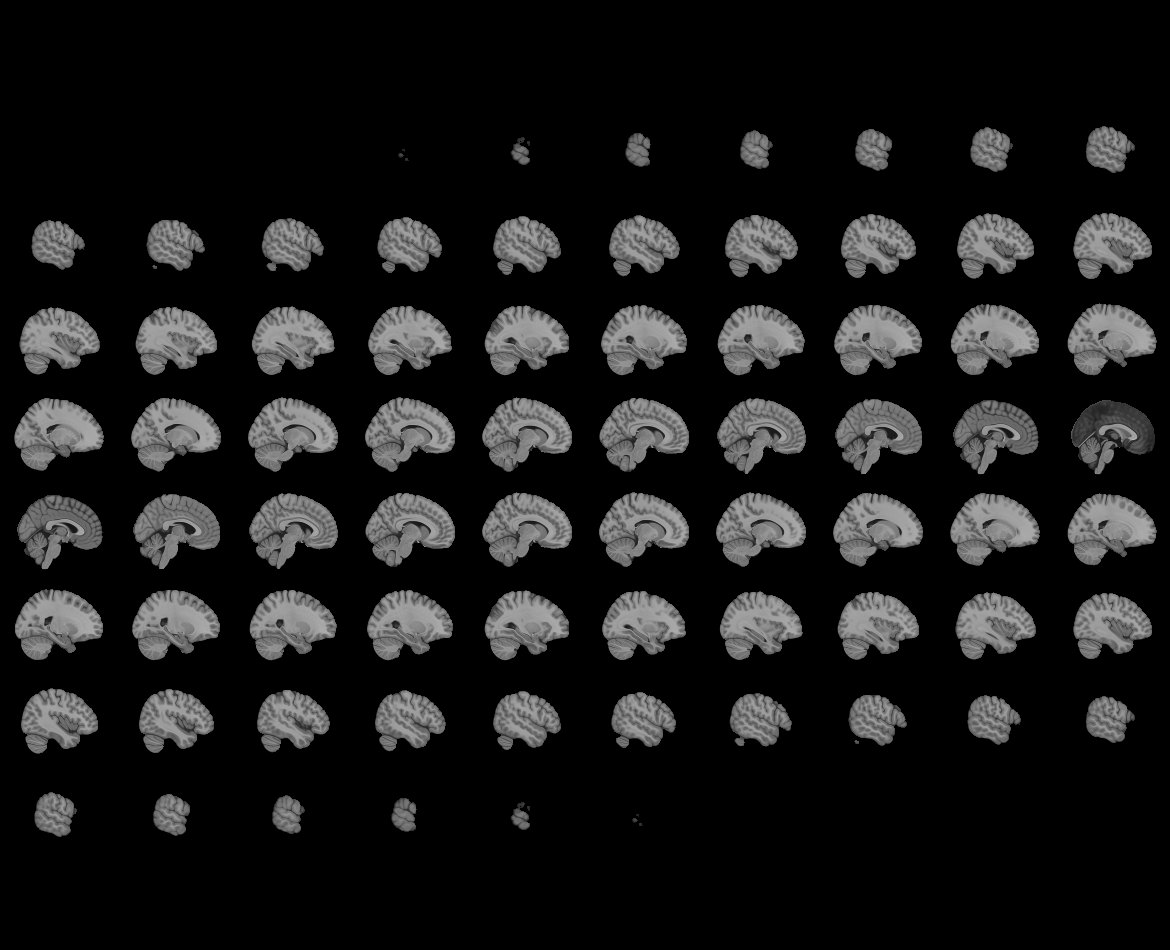
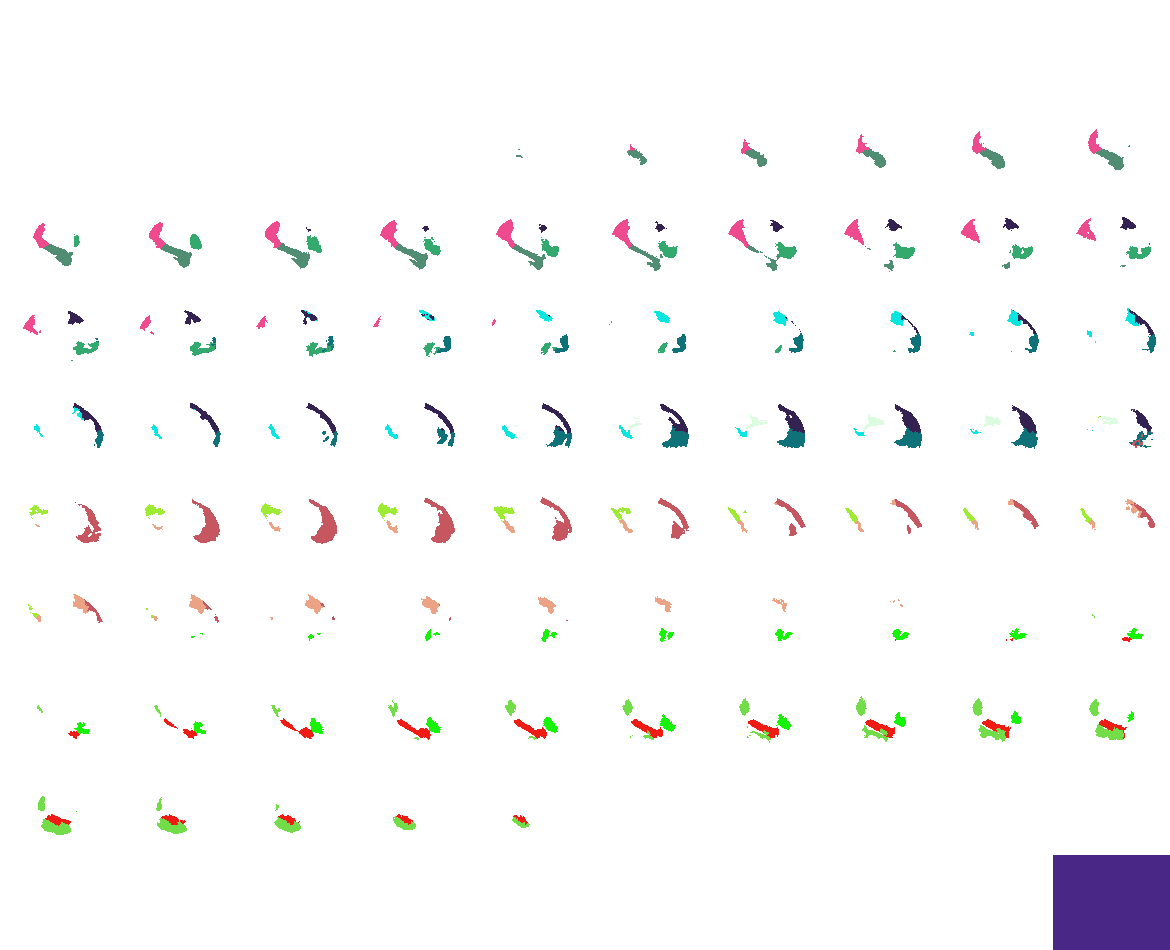

In [83]:
# TU RESPUESTA

# pista: puedes hacer un bucle que recorra labels y quedarte con los indices
#        en los que se encuentre una etiqueta que incluya la palabra "Default"

# cuidado! python comienza sus indices por 0

default_indices = [] #importante que crees esta lista que se usará más adelante

for i in labels:
    splited = i.split("_")
    for j in splited:
        if j == "Default":
            default_indices.append(labels.index(i))

print(default_indices)
# pista: puedes usar el objeto "atlas_data", que es una matriz numpy 3D, para
#        borrar todos los valores excepto los que se encuentren en tu lista de indices
atlas_data_dmn=np.zeros(atlas_data.shape)
for i in default_indices:
    atlas_data_dmn[atlas_data==i]=i

# pista: puedes crear una imagen visualizable con plotting.view_img() haciendo
default_img = nib.Nifti1Image(atlas_data_dmn, atlas_nii.affine)
nilearn.plotting.view_img(default_img, cmap=ListedColormap( np.random.rand(100, 3)), threshold=0)

## Atlas y series temporales

Ahora vamos a extraer las series temporales para cada ROI de la red Default y a visualizarlos. Para ello, la serie temporal de un ROI será el promedio de series temporales en todos los voxeles que pertenecen a esa ROI.

Primero, necesitaremos que Atlas e imagen BOLD tengan las mismas dimensiones (mismo numero de voxeles)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17208\3514057339.py:4: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  atlas_resampled = image.resample_to_img(atlas_nii, fmri_img, interpolation='nearest')
C:\Users\Usuario\anaconda3\Lib\site-packages\nilearn\image\resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


dimensiones atlas original -> (182, 218, 182)
dimensiones atlas adaptado -> (50, 59, 50)
dimensiones imagen fMRI -> (50, 59, 50, 168)


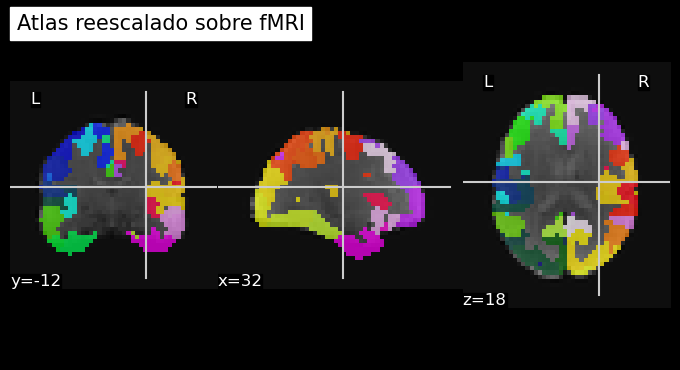

In [52]:
from nilearn import image

 # 1. Reescalar el atlas al espacio de la fMRI
atlas_resampled = image.resample_to_img(atlas_nii, fmri_img, interpolation='nearest')

print("dimensiones atlas original -> "+str(atlas_nii.shape))
print("dimensiones atlas adaptado -> "+str(atlas_resampled.shape))
print("dimensiones imagen fMRI -> "+str(fmri_img.shape))

from nilearn import plotting

# Tomar el primer volumen BOLD como imagen base
first_vol = fmri_img.slicer[..., 0]

# Visualizar atlas reescalado sobre el volumen base
plotting.plot_roi(atlas_resampled, bg_img=first_vol, title="Atlas reescalado sobre fMRI")
plotting.show()

Ahora, vamos a extraer las series temporales (promedio) de cada ROI y a graficar solo las de DMN:

ROIs a extraer:[37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


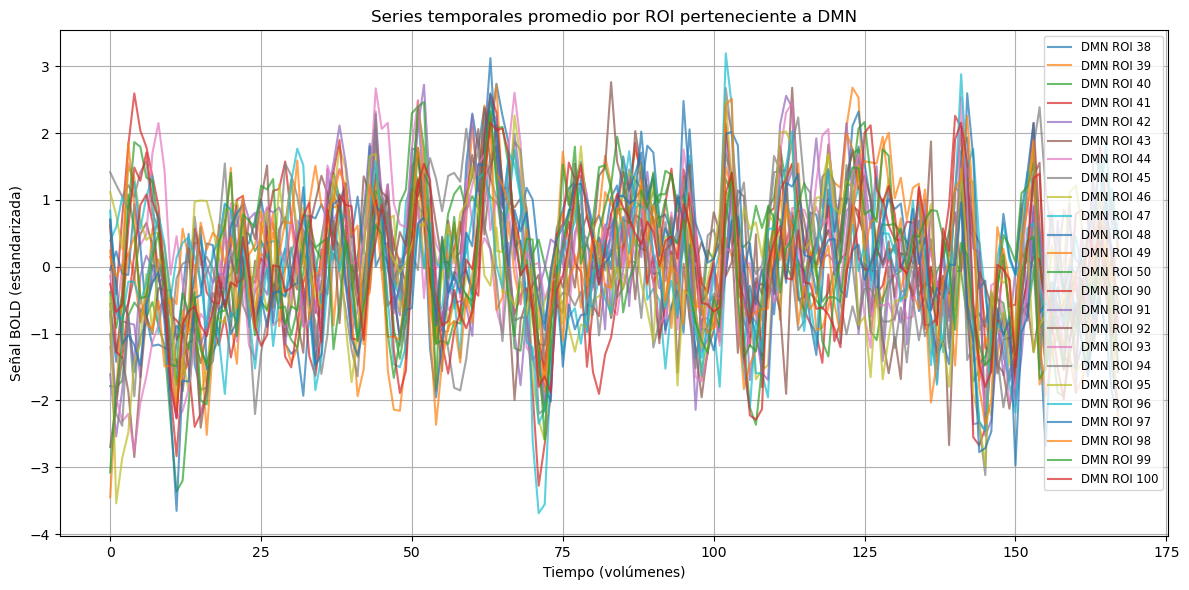

In [55]:
from nilearn.input_data import NiftiLabelsMasker
import matplotlib.pyplot as plt
print("ROIs a extraer:"+str(default_indices))

# 2. Crear masker con el atlas resampleado (ya en espacio de la fMRI)
masker = NiftiLabelsMasker(labels_img=atlas_resampled, standardize=True, detrend=True)

# 3. Extraer las series temporales promedio por ROI
time_series_all = masker.fit_transform(fmri_img)

# 4. Graficar las series temporales de todas las ROIs dentro de DMN
plt.figure(figsize=(12, 6))
for i in default_indices:
    plt.plot(time_series_all[:, i], label=f'DMN ROI {i+1}', alpha=0.7)
plt.title("Series temporales promedio por ROI perteneciente a DMN")
plt.xlabel("Tiempo (volúmenes)")
plt.ylabel("Señal BOLD (estandarizada)")
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()



## ROI based FC


La conectividad funcional se refiere al grado de correlación temporal entre las señales de distintas regiones del cerebro. En otras palabras, si dos regiones muestran patrones de actividad (derivados de señal BOLD) similares a lo largo del tiempo, se considera que están funcionalmente conectadas.

Para cuantificar la conectividad funcional, se suelen utilizar matrices de correlación de Pearson, donde cada celda (i, j) representa el nivel de conexión entre la región i y la región j.

En este ejercicio, vamos a calcular la matriz de conectividad funcional entre las 100 regiones definidas por el atlas de Schaefer.

Matriz de conectividad funcional (FC):
[[1.         0.38621836 0.51892509 ... 0.26060225 0.56636631 0.1808069 ]
 [0.38621836 1.         0.47082074 ... 0.34320215 0.35460682 0.17656153]
 [0.51892509 0.47082074 1.         ... 0.28331286 0.52384592 0.12137211]
 ...
 [0.26060225 0.34320215 0.28331286 ... 1.         0.46094185 0.6166484 ]
 [0.56636631 0.35460682 0.52384592 ... 0.46094185 1.         0.52468666]
 [0.1808069  0.17656153 0.12137211 ... 0.6166484  0.52468666 1.        ]]


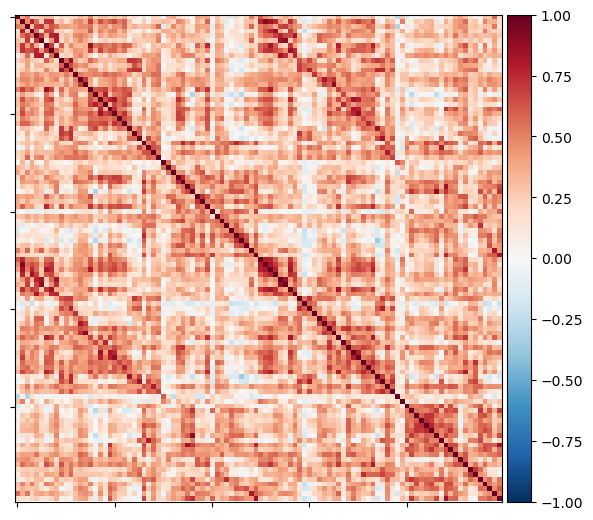

In [58]:
import numpy as np

# time_series_all: array shape (tiempo, ROIs)
# Matriz FC: correlación de Pearson entre cada par de columnas (ROIs)
fc_matrix = np.corrcoef(time_series_all.T)  # transponemos para correlacionar ROIs entre sí

print("Matriz de conectividad funcional (FC):")
print(fc_matrix)


from nilearn import plotting
plotting.plot_matrix(fc_matrix, vmin=-1., vmax=1., colorbar=True)

🤔 **Pregunta:** ¿Puedes comprobar que esta matriz sea simétrica? ¿Qué significa esto? ¿Por qué todos los elementos de la diagonal tienen valor 1?


In [ ]:
# TU CÓDIGO
np.allclose(fc_matrix,fc_matrix.T)

...TU RAZONAMIENTO...

## Visualizando networks
Para representar gráficamente la matriz de conectividad funcional (FC), primero se necesitan las coordenadas del centro de masa de cada ROI del atlas. Una vez obtenidos los centroides, vamos a utilizar la función plot_connectome de Nilearn para visualizar las conexiones funcionales como líneas entre regiones cerebrales, proporcionando una representación espacial intuitiva de las interacciones cerebrales más relevantes.

In [ ]:
import numpy as np
from scipy.ndimage import center_of_mass

# Obtener afín del atlas reescalado
affine = atlas_resampled.affine
atlas_data_resampled = atlas_resampled.get_fdata()
# ROIs reales (excluyendo fondo)
unique_rois = np.unique(atlas_data_resampled)
unique_rois = unique_rois[unique_rois != 0]

# Calcular centros de masa en espacio voxel y transformarlos a MNI
coords_centroids = []
for roi in unique_rois:
    com_voxel = center_of_mass(atlas_data_resampled == roi)
    com_mni = nib.affines.apply_affine(affine, com_voxel)
    coords_centroids.append(com_mni)

coords_centroids = np.array(coords_centroids)

from nilearn import plotting

plotting.plot_connectome(fc_matrix,coords_centroids)



Dado que muchas conexiones funcionales entre regiones cerebrales pueden ser débiles o ruidosas, vamos a aplicar un umbral basado en el percentil 97 de la matriz de conectividad funcional (FC). Esto permite visualizar únicamente las conexiones más fuertes y potencialmente más significativas desde el punto de vista funcional. El resultado es una red cerebral más limpia, destacando los principales "hubs" o núcleos de integración funcional en el cerebro.

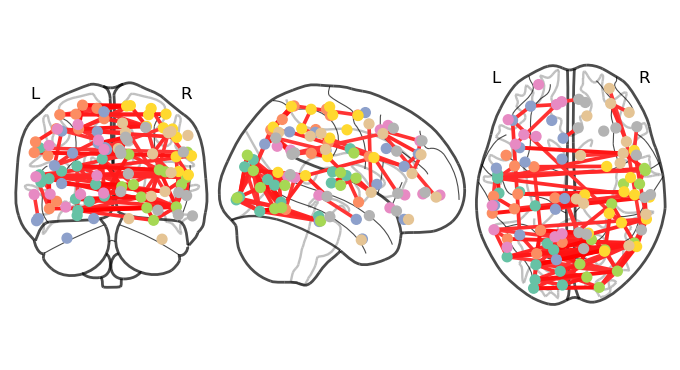

In [91]:
# Umbral para mostrar solo top X% conexiones
percentile = 97
threshold = np.percentile(np.abs(fc_matrix), percentile)

fc_thresh = np.copy(fc_matrix)
fc_thresh[np.abs(fc_thresh) < threshold] = 0

plotting.plot_connectome(fc_thresh, coords_centroids)

Por último, observemos en 3D e interactivamente!

In [93]:
view = plotting.view_connectome(fc_thresh, coords_centroids)
view